## Lab extension: text analysis of Ebola tweets
Researchers are often interested in the sentiment of natural language, particularly in the context of social media where positive and negative sentiment reflect the popular opinion of current unfolding events [(Thelwall, Buckley, Paltoglou 2011)](http://onlinelibrary.wiley.com/doi/10.1002/asi.21462/full).

Here's a hypothesis related to sentiment: the tweets that emerged at the height of the Ebola crisis are more likely to contain negative language than those that emerged before. For context, the CDC reported a steady increase in the number of Ebola cases reported from mid-2014 to mid-2015 ([Dixon and Schafer, 2014](https://www.cdc.gov/mmwr/preview/mmwrhtml/mm6325a4.htm?scid=mm6325a4w1)).

Formally:

$H_{0}$: In the collection of all Ebola-related tweets, the tweets posted at the end of the crisis have the same relative amount of negative sentiment as the tweets posted before.

$H_{1}$: In the collection of all Ebola-related tweets, the tweets posted at the end of the crisis have more negative sentiment than the tweets posted before.

This hypothesis follows from prior work in crisis events that shows a consistent pattern in social responses, from preparation to impact response to recovery ([Imran, Castillo, Diaz and Vieweg 2010](https://arxiv.org/pdf/1407.7071.pdf)). 

### Load data

Let's check out the time period in our original data to see if we have enough of a time scale to test the hypothesis.

In [2]:
import json
from datetime import datetime
decoder = json.JSONDecoder()
filename = 'ebola-tweets-short.json'
with open(filename) as fin:
    tweets = [decoder.decode(line) for line in fin.readlines()]
date_fmt = '%a %b %d %H:%M:%S +0000 %Y'
# "Thu Aug 28 15:34:30 +0000 2014"
tweet_dates = [datetime.strptime(t["created_at"], date_fmt) for t in tweets]
start_date = min(tweet_dates)
end_date = max(tweet_dates)
start_date_str = datetime.strftime(start_date, date_fmt)
end_date_str = datetime.strftime(end_date, date_fmt)
print('date range: [%s ... %s]'%(start_date_str, end_date_str))

date range: [Thu Aug 28 15:34:30 +0000 2014 ... Fri Aug 29 23:01:26 +0000 2014]


This time scale isn't nearly enough to cover a changing public opinion during the Ebola crisis, so let's extend the time period to last between August 28 and October 27 (two months).

I searched an archive of daily streaming Twitter data from 2014 for all tweets that contained the string "#Ebola", which may include both regular tweets and retweets.

I've stored the extra data here: [ebola_tweets_extra](ebola_tweets_extra.zip).

### Load extra data

In [34]:
# extract tweet data
from zipfile import ZipFile
archive = ZipFile('ebola_tweets_extra.zip', 'r')
ZipFile.extractall(archive)

In [35]:
import pandas as pd
import os
from functools import reduce
tweet_directory = 'ebola_tweets_extra/'
tweet_files = sorted(filter(lambda f: 'json' in f, os.listdir(tweet_directory)))
print(tweet_files)
tweet_data = reduce(lambda x,y: x+y, [[json.loads(l) for l in open(os.path.join(tweet_directory, f))] for f in tweet_files])
tweet_data_df = pd.DataFrame(tweet_data)
print('%d total tweets'%(tweet_data_df.shape[0]))

['Aug-28-14.json', 'Aug-29-14.json', 'Aug-30-14.json', 'Aug-31-14.json', 'Oct-01-14.json', 'Oct-02-14.json', 'Oct-03-14.json', 'Oct-04-14.json', 'Oct-05-14.json', 'Oct-06-14.json', 'Oct-07-14.json', 'Oct-08-14.json', 'Oct-09-14.json', 'Oct-10-14.json', 'Oct-11-14.json', 'Oct-12-14.json', 'Oct-13-14.json', 'Oct-14-14.json', 'Oct-15-14.json', 'Oct-16-14.json', 'Oct-17-14.json', 'Oct-18-14.json', 'Oct-19-14.json', 'Oct-20-14.json', 'Oct-21-14.json', 'Oct-22-14.json', 'Oct-23-14.json', 'Oct-24-14.json', 'Oct-25-14.json', 'Oct-26-14.json', 'Oct-27-14.json', 'Sep-01-14.json', 'Sep-02-14.json', 'Sep-03-14.json', 'Sep-04-14.json', 'Sep-05-14.json', 'Sep-06-14.json', 'Sep-07-14.json', 'Sep-08-14.json', 'Sep-09-14.json', 'Sep-10-14.json', 'Sep-11-14.json', 'Sep-12-14.json', 'Sep-13-14.json', 'Sep-14-14.json', 'Sep-15-14.json', 'Sep-16-14.json', 'Sep-17-14.json', 'Sep-18-14.json', 'Sep-19-14.json', 'Sep-20-14.json', 'Sep-21-14.json', 'Sep-22-14.json', 'Sep-23-14.json', 'Sep-24-14.json', 'Sep-25-1

There's probably a lot of noise in here, so let's cut out the non-English data first.

In [6]:
from langid import classify
lang = 'en'
tweet_data_df.loc[:, 'lang'] = tweet_data_df.loc[:, 'text'].apply(lambda t: classify(t)[0])
tweet_data_filtered_df = tweet_data_df[tweet_data_df['lang'] == 'en']
print('%d / %d tweets are English'%(tweet_data_filtered_df.shape[0], tweet_data_df.shape[0]))

36591 / 48182 tweets are English


Let's get a sense of what's going on in this data by looking at the most frequent hashtags.

In [7]:
from collections import Counter
hashtag_lists = tweet_data_filtered_df.loc[:, 'entities'].apply(lambda e: [h['text'] for h in e['hashtags']])
hashtag_list = reduce(lambda x,y: x+y, hashtag_lists)
hashtag_counts = pd.Series(Counter(hashtag_list)).sort_values(inplace=False, ascending=False)
print(hashtag_counts[:20])

Ebola            31605
EbolaOutbreak     1309
tcot               766
Liberia            636
EbolaResponse      626
CDC                620
BREAKING           604
ebola              553
SierraLeone        518
ISIS               510
Africa             489
Obama              446
Nigeria            377
Dallas             353
EbolaCzar          299
EbolaQandA         247
Texas              217
NEWS               194
EbolaInNYC         170
Guinea             160
dtype: int64


These all seem reasonable, since the 2014 Ebola outbreak was centered in West Africa (Nigeria, Liberia, Guinea).

### Sentiment

Our hypothesis concerns negative sentiment, which we will measure by counting the number of negative words in a tweet.

For sentiment, we'll use a Twitter sentiment lexicon developed for the 2015 SemEval task (Rosenthal et al. 2015), available [here](http://saifmohammad.com/WebDocs/lexiconstoreleaseonsclpage/SemEval2015-English-Twitter-Lexicon.zip) and stored locally [here](SemEval2015-English-Twitter-Lexicon.txt).

In [8]:
sentiment_file = 'SemEval2015-English-Twitter-Lexicon.txt'
sentiment_scores = pd.read_csv(sentiment_file, sep='\t', index_col=False)
sentiment_scores.columns = ['score', 'ngram']
sentiment_scores.sort_values('score', inplace=True, ascending=False)
print(sentiment_scores.head())
print(sentiment_scores.tail())

   score           ngram
0  0.984  #inspirational
2  0.969       #peaceful
1  0.969         amazing
3  0.953      #greatness
4  0.938       fantastic
      score            ngram
1509 -0.969            abuse
1510 -0.969         #failure
1511 -0.982             kill
1512 -0.984          bitches
1513 -0.984  #disappointment


The extrema seem to make sense: positive words include "amazing" and negative words include "kill."

Let's see what different cross-sections of scores look like.

In [9]:
percentiles = pd.np.linspace(10, 100, 10)
sentiment_score_values = sentiment_scores['score']
for p in percentiles:
    print('testing percentile %d'%(p))
    sentiment_scores_p = sentiment_scores[sentiment_score_values < pd.np.percentile(sentiment_score_values, p)]
    print(sentiment_scores_p.head())

testing percentile 10
      score       ngram
1373 -0.732       #lazy
1374 -0.732  #repulsive
1382 -0.734      rotten
1387 -0.734     #idiots
1386 -0.734        fail
testing percentile 20
      score     ngram
1220 -0.516  scariest
1223 -0.516   #grumpy
1222 -0.516     #dumb
1221 -0.516     leave
1218 -0.516      shot
testing percentile 30
      score        ngram
1077 -0.344        sorry
1080 -0.344         argh
1079 -0.344  no sympathy
1078 -0.344  don't drink
1076 -0.344        media
testing percentile 40
     score          ngram
916 -0.141          makes
922 -0.141  can't believe
921 -0.141           site
920 -0.141           head
919 -0.141     can't wrap
testing percentile 50
     score    ngram
766  0.016   nearly
768  0.016      guy
769  0.016    guess
770  0.016   sounds
771  0.016  heading
testing percentile 60
     score      ngram
610  0.161      start
619  0.156      books
627  0.156       poem
626  0.156  #hardwork
625  0.156        try
testing percentile 70
     score  

It seems like the most reliable ngrams are at the extrema of the distribution: for instance, I wouldn't trust a positive score from the word "poem" (0.156) or a negative score from the word "makes" (-0.141).

Decision: we will only count a word as having a label of "negative" or "positive" if its absolute score exceeds cutoff $c=0.5$.

In [10]:
cutoff = 0.5
sentiment_scores_filtered = sentiment_scores[abs(sentiment_scores['score']) > cutoff]
print('%d total sentiment labels'%(len(sentiment_scores_filtered)))
# round labels
sentiment_labels = sentiment_scores['score'].apply(round)
sentiment_labels.index = sentiment_scores['ngram']
print(sentiment_labels.head())

595 total sentiment labels
ngram
#inspirational    1
#peaceful         1
amazing           1
#greatness        1
fantastic         1
Name: score, dtype: float64


Let's clean up the hashtags to make them more extensible to regular text.

In [11]:
sentiment_labels.index = map(lambda x: x.replace('#', ''), sentiment_labels.index)
sentiment_vocab = sentiment_labels.index.tolist()

### Extracting sentiment labels

We now extract sentiment from the text using a very simple counting method.

Assuming a lexicon for positive words $P$ and negative words $N$, we assign a label of positive or negative ($k=1,-1$) to a tweet based on the sum of the sentiment labels $l$ of the tweet's words:

$$
\begin{equation}
f(x) = 
\begin{cases}
1 & \text{if} \sum_{w \in x} l_{x} > 0 \\ 
-1 & \text{if} \sum_{w \in x} l_{x} < 0 \\ 
0 & \text{otherwise}
\end{cases}
\end{equation}
$$

Obviously this is only a binary representation of sentiment that fails to capture more complex linguistic phenomena such as negation, but it's a start.

In [19]:
from nltk.tokenize.casual import TweetTokenizer
TOKENIZER = TweetTokenizer()
def assign_sentiment_label(text, positive_lexicon, negative_lexicon):
    tokens = TOKENIZER.tokenize(text)
    positive_tokens = [w for w in tokens if w in positive_lexicon]
    negative_tokens = [w for w in tokens if w in negative_lexicon]
    positive_score = len(positive_tokens)
    negative_score = -1*len(negative_tokens)
    score = positive_score + negative_score
    if(score <= -1):
        return -1
    elif(score >= 1):
        return 1
    else:
        return 0
positive_lexicon = sentiment_labels[sentiment_labels == 1].index.tolist()
negative_lexicon = sentiment_labels[sentiment_labels == -1].index.tolist()
tweet_sentiment_labels = tweet_data_filtered_df['text'].apply(lambda x: assign_sentiment_label(x, positive_lexicon, negative_lexicon))
tweet_data_filtered_df = tweet_data_filtered_df.assign(sentiment_label=tweet_sentiment_labels)

Let's look at a histogram of the labels to see the overall distribution of positive and negative labels.

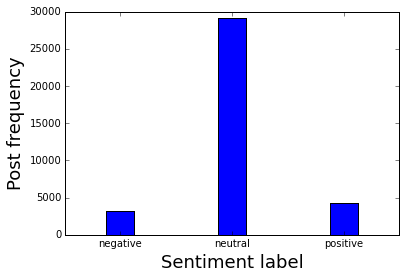

In [14]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
tweet_sentiment_counts = tweet_data_filtered_df['sentiment_label'].value_counts()
xticks = pd.np.array(tweet_sentiment_counts.index)
width = 0.25
xtick_labels = ['negative', 'neutral', 'positive']
plt.bar(xticks - width / 2., tweet_sentiment_counts, width=width)
plt.xticks([-1,0,1], xtick_labels)
plt.xlabel('Sentiment label', fontsize=18)
plt.ylabel('Post frequency', fontsize=18)
plt.show()

Interesting! There are relatively few positive and negative tweets.

This could make hypothesis testing more difficult, unless we propose an alternative version where positive sentiment declines as the crisis progresses. This would be similar to the emotional contagion study which proposed both increased activation and decreased inhibition in response to emotions expressed by one's friends.

### Sanity check
Let's make sure that the tweets classified as positive are actually positive and the tweets classified as negative are actually negative.

In [17]:
pd.np.random.seed(123)
sample_size = 5
positive_tweet_text = tweet_data_filtered_df[tweet_data_filtered_df['sentiment_label'] == 1]['text']
negative_tweet_text = tweet_data_filtered_df[tweet_data_filtered_df['sentiment_label'] == -1]['text']
positive_sample = pd.np.random.choice(positive_tweet_text, size=sample_size)
negative_sample = pd.np.random.choice(negative_tweet_text, size=sample_size)
print('positive sample:\n%s\n'%('\n'.join(positive_sample)))
print('negative sample:\n%s\n'%('\n'.join(negative_sample)))
print('positive tokens:\n%s\n'%('\n'.join([','.join(set(positive_lexicon) & set(TOKENIZER.tokenize(x))) for x in positive_sample])))
print('negative tokens:\n%s\n'%('\n'.join([','.join(set(negative_lexicon) & set(TOKENIZER.tokenize(x))) for x in negative_sample])))

positive sample:
“@fox32news: UPDATED STORY: Dallas nurse Nina Pham now #Ebola-free http://t.co/iNCHFHja27 http://t.co/pTDRL2Coqq” that's great😬
Lupica: Ebola has traveled from Guinea to New York, but the city is ready http://t.co/z1RUQdPZvZ
#Ebolaisreal #Ebolaisnotpolitics
I'm glad there's an #EbolaOutbreak makes it sooo much easier for me to cancel on people *cough lol
RT @UNICEF: Social mobilizers teach locals like Uchechi how to protect themselves from #Ebola in #Nigeria. http://t.co/JRTkeytTxr http://t.…
CDC head says more health care workers could have #Ebola , despite claiming ‘any hospital’... http://t.co/zMrYUe2Yns

negative sample:
RT @UNICEFSL: Survivors conf now in Kenema: She survived #Ebola. Her mother survived. Her two siblings survived. Her father died. http://t.…
RT @WHO: He did not cry when his mother died of #Ebola because he didn’t want to scare his brothers http://t.co/2QmvZd9Rju http://t.co/DyFY…
RT @edwrather: Watchdog: Obama to bring African Ebola victims to U.S

Positive tweets have some unambiguously good words, such as "great" and "ready," but there is also some ambiguity with words like "care" that are less positive.

Negative tweets describe the relevant bad outcomes, such as "died" and "death." We expect these words to become more common as the crisis progresses in time.

### Test hypothesis
Let's start by assuming that the split point between "start" and "end" is the exact middle of the data.

In [20]:
date_fmt = '%a %b %d %H:%M:%S +0000 %Y'
created_at_datetime=tweet_data_filtered_df.loc[:, 'created_at'].apply(lambda x: datetime.strptime(x, date_fmt))
tweet_data_filtered_df = tweet_data_filtered_df.assign(created_at_datetime=created_at_datetime)
all_dates = tweet_data_filtered_df.loc[:, 'created_at_datetime']
# get unique days, then get the median day
all_dates_unique_days = sorted(all_dates.apply(lambda x: datetime(*x.timetuple()[:3])).unique())
N = len(all_dates_unique_days)
split_point = int(N/2)
median_date = all_dates_unique_days[split_point]
print('split at date %s'%(median_date))

split at date 2014-09-27T00:00:00.000000000


In [21]:
tweet_data_before = tweet_data_filtered_df[tweet_data_filtered_df['created_at_datetime'] <= median_date]
tweet_data_after = tweet_data_filtered_df[tweet_data_filtered_df['created_at_datetime'] > median_date]

Now let's plot the distribution of sentiment before and after the split point, as a boxplot.

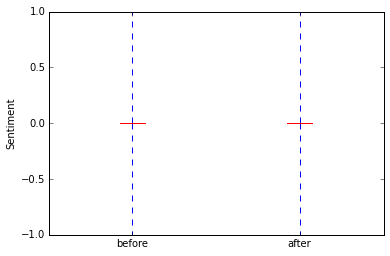

In [22]:
box_data = [tweet_data_before['sentiment_label'].values, tweet_data_after['sentiment_label'].values]
plt.boxplot(box_data, labels=['before', 'after'])
plt.ylabel('Sentiment')
plt.show()

This plot isn't too informative. What if we just look at the mean and standard deviation of sentiment?

In [23]:
from scipy.stats import ttest_ind
print('before: sentiment mean = %.3f +/- %.3f'%(tweet_data_before['sentiment_label'].mean(), tweet_data_before['sentiment_label'].std()))
print('after: sentiment mean = %.3f +/- %.3f'%(tweet_data_after['sentiment_label'].mean(), tweet_data_after['sentiment_label'].std()))
sentiment_diff = tweet_data_after['sentiment_label'].mean() - tweet_data_before['sentiment_label'].mean()
t_stat, p_val = ttest_ind(tweet_data_after['sentiment_label'], tweet_data_before['sentiment_label'])
print('mean difference in sentiment before and after split point is %3f, significant with t=%.3f and p=%.3E'%
      (sentiment_diff, t_stat, p_val))

before: sentiment mean = 0.005 +/- 0.407
after: sentiment mean = 0.031 +/- 0.457
mean difference in sentiment before and after split point is 0.025315, significant with t=3.784 and p=1.547E-04


Interesting! It looks like the average sentiment increased slightly (0.0253, p < 0.01) between the time periods.

### Update hypothesis: sentiment as a categorical variable

It might make sense to see sentiment as more of a categorical variable, meaning that we should look for a change in percentage of negative posts rather than a change in the overall distribution.

Updated hypothesis:

$H_{0}$: the proportion of negative Ebola tweets is not higher at the end of the time period observed than at the beginning of the time period observed.

$H_{1}$: the proportion of negative Ebola tweets is higher at the end of the time period observed than at the beginning of the time period observed.

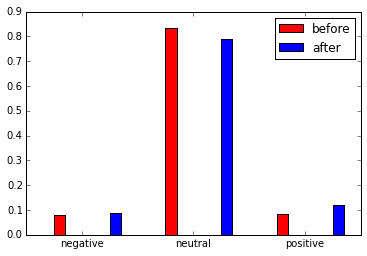

In [24]:
tweet_data_before_sentiment_pcts = tweet_data_before['sentiment_label'].value_counts() / tweet_data_before.shape[0]
tweet_data_after_sentiment_pcts = tweet_data_after['sentiment_label'].value_counts() / tweet_data_after.shape[0]
tweet_data_before_sentiment_pcts.sort_index(inplace=True)
tweet_data_after_sentiment_pcts.sort_index(inplace=True)
x_offset = 0.25
bar_width = 0.1
x_pos = pd.np.arange(len(tweet_data_after_sentiment_pcts))
x_ticklabels = ['negative', 'neutral', 'positive']
plt.bar(x_pos-x_offset, tweet_data_before_sentiment_pcts, color='r', label='before', width=bar_width)
plt.bar(x_pos+x_offset, tweet_data_after_sentiment_pcts, color='b', label='after', width=bar_width)
plt.xticks(x_pos, x_ticklabels)
plt.legend(loc='upper right')
plt.show()

It looks like the amount of positive sentiment increased slightly and neutral sentiment decreased slightly. I don't see a significant change in negative sentiment.

We should do a sampling hypothesis test to determine if the changes are significant.

In [25]:
def sentiment_label_test(all_data, split_index, sentiment_label, samples=1000):
    """
    Repeatedly shuffle the data and split to produce
    the same amount of before/after data, then
    test the null hypothesis that the randomized
    after-data has a more extreme sentiment than the before-data.
    
    Parameters:
    -----------
    all_data : pandas.Series
    split_index : int
    sentiment_label : int
    samples : int
    
    Returns:
    --------
    p_val : float
    Proportion of null hypothesis tests that succeeded.
    """
    pct_diff = lambda samp : (len(samp[split_index:][samp[split_index:]==sentiment_label]) / len(samp[split_index:]) - 
                              len(samp[:split_index][samp[:split_index]==sentiment_label]) / len(samp[:split_index]))
    get_samp = lambda data: data[pd.np.random.choice(range(len(data)), size=len(data), replace=False)]
    h1_val = pct_diff(all_data)
    h0_vals = [pct_diff(get_samp(all_data)) for _ in range(samples)]
    if(h1_val < 0):
        p_val = sum([h0 < h1_val for h0 in h0_vals]) / samples
    elif(h1_val > 0):
        p_val = sum([h0 > h1_val for h0 in h0_vals]) / samples
    return p_val

In [26]:
samples = 1000
sentiment_labels_unique = tweet_data_filtered_df['sentiment_label'].unique()
pct_diff = lambda samp : (len(samp[split_index:][samp[split_index:]==sentiment_label]) / len(samp[split_index:]) - 
                          len(samp[:split_index][samp[:split_index]==sentiment_label]) / len(samp[:split_index]))
sentiment_label_values = tweet_data_filtered_df['sentiment_label'].values
split_index = pd.np.where(tweet_data_filtered_df['created_at_datetime'] > median_date)[0][0]
for sentiment_label in sentiment_labels_unique:
    test_p_val = sentiment_label_test(sentiment_label_values, split_index, sentiment_label, samples=samples)
    before_after_diff = pct_diff(sentiment_label_values)
    print('for sentiment label %d after-before difference %.3E is significant with p-value %.3E'%
          (sentiment_label, before_after_diff, test_p_val))

for sentiment label 0 after-before difference -6.115E-02 is significant with p-value 0.000E+00
for sentiment label 1 after-before difference 5.980E-02 is significant with p-value 0.000E+00
for sentiment label -1 after-before difference 1.349E-03 is significant with p-value 4.280E-01


The increase in negative sentiment is small (0.135%) and insignificant (p > 0.05), and it's actually a decrease.

Interestingly, the positive sentiment increased by more than an order of 10 greater than negative sentiment (5.98%, p < 0.001), which was not expected. 

The apparent increase in sentiment may be due to the negation problem observed earlier, where "more positive" really just means more more phrases containing negation of positive words (e.g., "no support").

**Conclusion**:

We cannot reject the null hypothesis that the proportion of negative sentiment did not increase from the start to the end of the time period observed. 

We can reject a new hypothesis with more than 99% confidence that positive sentiment did not increase from the start to the end of the time period observed, because we observe a significant increase in proportion of tweets with positive sentiment.

## Better test: increase over time
Instead of using a simple two-population hypothesis test to test the increase in negative sentiment, we should really frame this as a time series analysis, where the metric of interest is the change in negative sentiment per day.

$H_{0}$: there is no significant change over time in the proportion of posts containing negative sentiment posted on a daily basis.

$H_{1}$: there is a significant change over time in the proportion of posts containing negative sentiment posted on a daily basis.

### Compute daily negative percentage
Compute the per-day proportion of tweets containing negative sentiment.

In [27]:
# round date to day-of
day_round = lambda x: datetime(*x.timetuple()[:3])
datetime_day = tweet_data_filtered_df.loc[:, 'created_at_datetime'].apply(day_round)
tweet_data_filtered_df = tweet_data_filtered_df.assign(created_at_datetime_day=datetime_day)
# tweet_data_filtered_df.loc[:, 'created_at_datetime_day'] = tweet_data_filtered_df.loc[:, 'created_at_datetime'].apply(day_round)
sentiment_label = -1
compute_daily_sentiment = lambda x: x[x['sentiment_label'] == sentiment_label].shape[0] / x.shape[0]
per_day_negative_sentiment_pct = tweet_data_filtered_df.groupby('created_at_datetime_day').apply(compute_daily_sentiment)

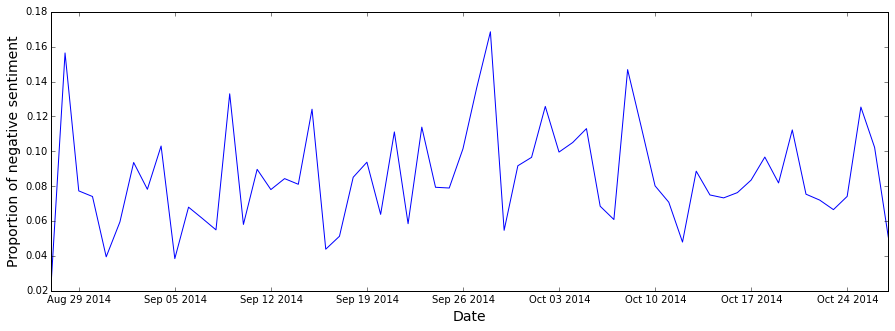

In [28]:
# plot
plt.figure(figsize=(15,5))
plt.plot(per_day_negative_sentiment_pct.index, per_day_negative_sentiment_pct)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Proportion of negative sentiment', fontsize=14)
plt.show()

It looks like a stationary process to me, meaning that any "change" observed is the result of regular fluctuation. 

We can test this null hypothesis using the agumented Dickey-Fuller test ([Dickey and Fuller 1979](http://www.jstor.org/stable/2286348)), which tests the null hypothesis that a time series is generated by a unit root (e.g. steady growth). We model the sentiment time series $y$ as follows: 

$$y_{t} = \alpha + \beta{}t + \gamma y_{t-1} + \epsilon_{t} + \sum_{i=1}^{p-1} \delta_{p}\Delta{}y_{t-i}$$

The key here is the lag coefficient $\gamma$, which determines how much of the time series value at time $t$ is explained by the time series value at the previous timestep $t-1$. 

We are interested in knowing whether the time series can be explained as a process of constant growth or decline with a unit root (i.e., $\gamma=0$). We therefore fit an autoregressive regression model to the data using the equation above and use the following test statistic to determine whether the lag coefficient is significantly different from 0:

$$ t = \frac{\hat{\gamma} - 0}{SE(\hat{\gamma})} $$

If the test statistic is more negative than a critical value, we can reject the null hypothesis that $\gamma=0$ and therefore reject the hypothesis that a unit root exists.

In [29]:
from statsmodels.tsa.stattools import adfuller
test_result = adfuller(per_day_negative_sentiment_pct)
print(test_result)
print('the test statistic for the augmented Dickey-Fuller test is %.3f, p=%.3E'%(test_result[0], test_result[1]))

(-8.3733223003432098, 2.6263558061018832e-13, 0, 61, {'1%': -3.5424127466616149, '10%': -2.5927445767266866, '5%': -2.9102362358082838}, -214.82385148248238)
the test statistic for the augmented Dickey-Fuller test is -8.373, p=2.626E-13


We therefore reject the possibility that the negative sentiment time series has a unit root and assume that the series is stationary, i.e. no noticeable growth or decline trend.

### Discussion

We find a slight decrease in both negative and positive sentiment over time. At first glance this is surprising because one would expect that the increased deaths over time due to Ebola (Dixon, Schafer 2014) would engender more negative sentiment shared around the topic on social media. However, it may be the case that the growing awareness of the Ebola outbreak over time led to discussion among a wider audience that engendered more neutral statements (explaining the increase in proportion of neutral statements).

This study may be refined through a more careful sentiment extraction scheme that accounts for negation. It would also be interesting to use a sentiment lexicon that does not include words like "death" and "dying" to see if the same results hold: I suspect that a large proportion of the "negative" Ebola tweets are simply reporting the facts about the death rates, while the more interesting negative sentiment tweets would contain more subjective language such as "sad" and "devastating." Lastly, we did not use a weighted lexicon which could reveal more variation within the positive and negative tweets, such that even if negative sentiment remains steady over time the average weight of the negative sentiment might still grow. 

Furthermore, this study looked at sentiment across time but could have benefited from further population segmentation. For instance, did tweets originating from countries closer to the Ebola outbreak exhibit more negative sentiment? I would expect this to be true simply because fears of contagion would seem to be stronger among populations closer to the Ebola outbreak.

### References
Dickey, D. A., & Fuller, W. A. (1979). Distribution of the estimators for autoregressive time series with a unit root. Journal of the American statistical association, 74(366a), 427-431.

Dixon, M. G., & Schafer, I. J. (2014). Ebola viral disease outbreak—West Africa, 2014. MMWR Morb Mortal Wkly Rep, 63(25), 548-51.

Imran, M., Castillo, C., Diaz, F., & Vieweg, S. (2015). Processing social media messages in mass emergency: A survey. ACM Computing Surveys (CSUR), 47(4), 67.

Rosenthal, S., Nakov, P., Kiritchenko, S., Mohammad, S., Ritter, A., & Stoyanov, V. (2015, June). SemEval-2015 Task 10: Sentiment Analysis in Twitter. In SemEval@ NAACL-HLT (pp. 451-463).

Thelwall, M., Buckley, K., & Paltoglou, G. (2011). Sentiment in Twitter events. Journal of the Association for Information Science and Technology, 62(2), 406-418.